# Self-Driving Car Engineer Nanodegree

## Traffic Sign Classifier
## John Mansell

# Set Up
---

### Import Modules

In [1]:
import pickle
from sklearn.utils import shuffle
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import cv2
import pickle

# local modules
import helper_functions
%run helper_functions.py

# Visualizations will be shown in the notebook.
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


### Hyper Parameters

In [2]:
# mu and sigma used for tf.truncated_normal,
# randomly defines variables for the weights and biases for each layer

EPOCHS = 100
BATCH_SIZE = 64

mu = 0
sigma = 0.1

rate = 0.001
epsilon = 1.0

color = cv2.COLOR_RGB2GRAY

# Clear Graph
tf.reset_default_graph()

### Load The Data

In [3]:
# Load Pickled Data
training_file = "images_and_label_data/train.p"
validation_file = "images_and_label_data/valid.p"
testing_file = "images_and_label_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_images, train_labels = train['features'], train['labels']
valid_images, valid_lables = valid['features'], valid['labels']
test_images, test_labels = test['features'], test['labels']

# Log Path for Tensorboard
logs_path = "./tensor_board"

### References to the Data and Labels

In [4]:
X_train = np.array(train_images)
y_train = train_labels

X_valid = np.array(valid_images)
y_valid = valid_lables

X_test = test_images
y_test = test_labels

# Visualize the Data
---

### Basic Summary of the Data

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of Images\n-----------------")
print("Train -- ", n_train)
print("Valid -- ", n_validation)
print("Test  -- ", n_test)
print()
print("Dimensions of each Image -- ", image_shape)
print("Number of Uniqe traffic Signs -- ", n_classes)

Number of Images
-----------------
Train --  34799
Valid --  4410
Test  --  12630

Dimensions of each Image --  (32, 32, 3)
Number of Uniqe traffic Signs --  43


### Sample picture for each class of images

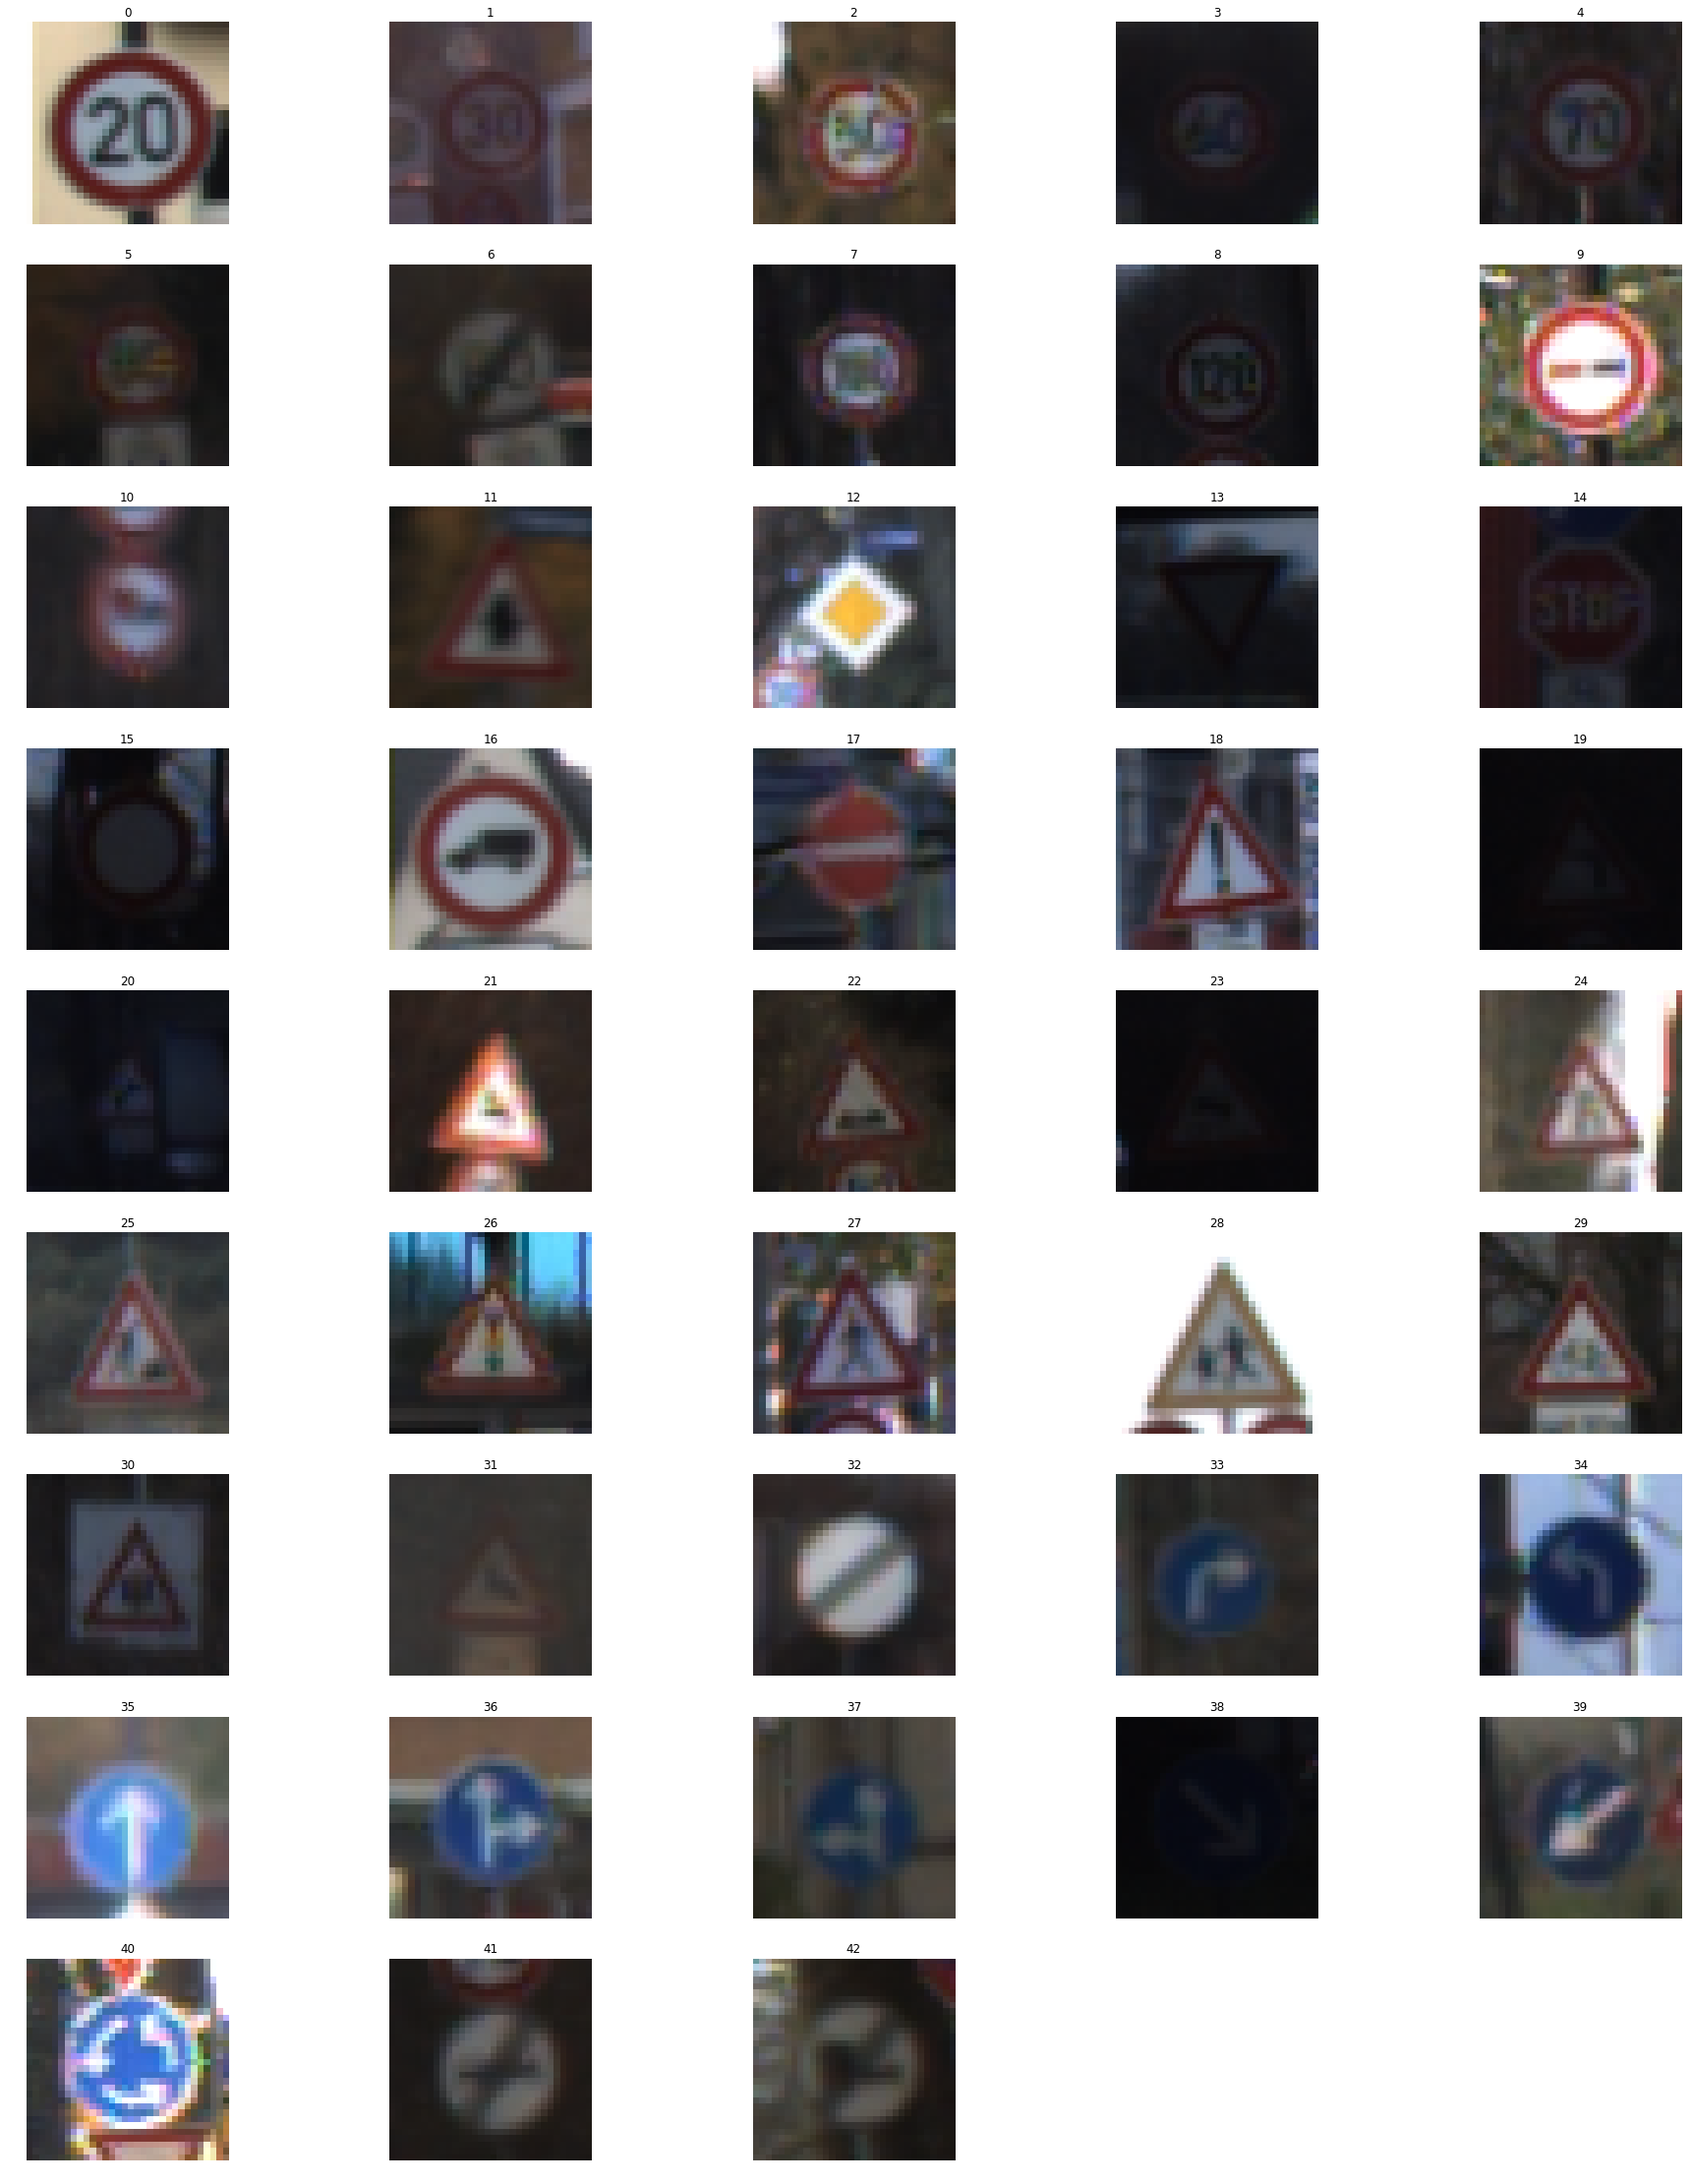

In [6]:
%run helper_functions.py

fig = plt.figure(figsize=(32, 40))
columns = 5
rows = 9

for i in range(n_classes):
    
    # Find image with label = label
    index = 0
    while(y_train[index] != i):
        index += 1
        
    fig.add_subplot(rows, columns, i+1)
    image = X_train[index]
    plt.imshow(image)
    plt.title(i)
    plt.axis('off')
    
plt.savefig('images_and_label_data/writeup_images/samples', bbox_inches='tight')
plt.show()  

### Distribution of Data

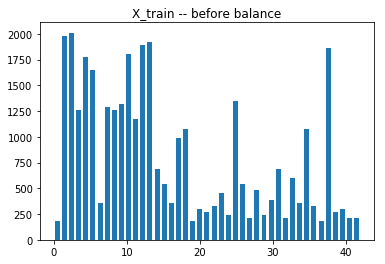

In [7]:
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title("X_train -- before balance")
plt.savefig('images_and_label_data/writeup_images/hist_1',bbox_inches='tight')
plt.show()

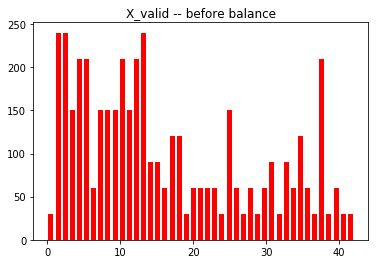

In [8]:
hist, bins = np.histogram(y_valid, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='red')
plt.title("X_valid -- before balance")
plt.savefig('images_and_label_data/writeup_images/hist_valid_1', bbox_inches='tight')
plt.show()

# Pre Process the Data

### Balance the Data Set

In [9]:
# Merge training and validation images
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

# Shuffle merged data sets
X_train, y_train = shuffle(X_train, y_train)

hist, bins = np.histogram(y_train, bins=n_classes)
average = 2000

image_copies = []
label_copies = []


for image, label in zip(X_train, y_train):
    if hist[label] < average:
        difference = (average - hist[label])
        x_range = int(difference / hist[label])
        for i in range(x_range):
            new_image = helper_functions.random_translate(image)
            new_image = helper_functions.random_brightness(image)
            new_image = helper_functions.random_scale(image)
            image_copies.append(new_image)
            label_copies.append(label)

X_train = np.concatenate((X_train, image_copies), axis=0)
y_train = np.concatenate((y_train, label_copies), axis=0)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)


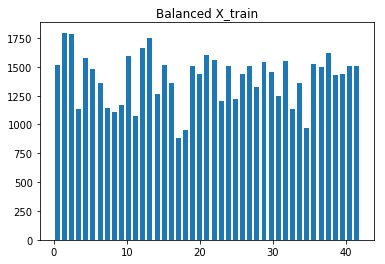

In [10]:
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('Balanced X_train')
plt.savefig('images_and_label_data/writeup_images/hist_2', bbox_inches='tight')
plt.show()

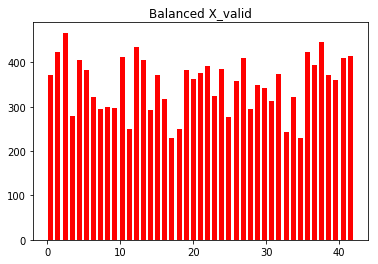

In [11]:
hist, bins = np.histogram(y_valid, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='red')
plt.title("Balanced X_valid")
plt.savefig('images_and_label_data/writeup_images/hist_valid_2', bbox_inches='tight')
plt.show()

### Convert to grayscale

In [12]:
if color is not None:
    X_train_new = []
    X_test_new = []
    X_valid_new = []

    for image in X_train:
        new_img = cv2.cvtColor(image, color)
        X_train_new.append(new_img)

    for image in X_test:
        new_img = cv2.cvtColor(image, color)
        X_test_new.append(new_img)

    for image in X_valid:
        new_img = cv2.cvtColor(image, color)
        X_valid_new.append(new_img)

    X_train_new = np.array(X_train_new)
    X_test_new = np.array(X_test_new)
    X_valid_new = np.array(X_valid_new)

    X_train = X_train_new
    X_test = X_test_new
    X_valid = X_valid_new

### Shuffle the Data

In [13]:
# Shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

### Normalize the Data

In [14]:
img_max = np.max(X_train)

X_train = (X_train / img_max) - 0.5
X_valid = (X_valid / img_max) - 0.5
X_test = (X_test / img_max) - 0.5

print("Mean 2", np.mean(X_train))

Mean 2 -0.186452749757


----

# Step 2: Model Architecture

### Layer Definitions

In [15]:
def convolution(x, W, b, name=None):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    conv = tf.nn.bias_add(conv, b)
    conv = tf.nn.elu(conv, name=name)
    return conv


def maxpool2d(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

### Model Architecture
> Modified LeNet architecture

In [16]:
def LeNet(x):

    # Conv 1:
    conv1 = convolution(x, weights['w_conv1'], biases['b_conv1'], name='conv1')
    conv1 = maxpool2d(conv1)

    # Conv 2
    conv2 = convolution(conv1, weights['w_conv2'], biases['b_conv2'], name='conv2')
    conv2 = maxpool2d(conv2)

    # Conv 3
    conv3 = convolution(conv2, weights['w_conv3'], biases['b_conv3'], name='conv3')

    # Flatten
    conv2_flat = flatten(conv2)
    conv3_flat = flatten(conv3)
    fc0 = tf.concat([conv2_flat, conv3_flat], 1)

    # Dropout
    fc0 = tf.nn.dropout(fc0, dropout)

    # Fully Connected 1
    fc1 = tf.matmul(fc0, weights['w_fc1']) + biases['b_fc1']
    fc1 = tf.nn.elu(fc1, name='fc1')

    # Fully Connected 2
    fc2 = tf.matmul(fc1, weights['w_fc2']) + biases['b_fc2']
    fc2 = tf.nn.elu(fc2, name='fc2')

    # Fully Connected 3
    logits = tf.matmul(fc2, weights['w_fc3']) + biases['b_fc3']

    return logits

### Features and Labels
> Input

In [17]:
# Get Image depth (color channels)
if len(X_train.shape) > 3:
    placeholder_shape = (None, 32, 32, 3)
    depth = 3
else:
    placeholder_shape = (None, 32, 32, 1)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
    X_valid = np.expand_dims(X_valid, axis=3)
    depth = 1

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, placeholder_shape, name='x-input')
    y = tf.placeholder(tf.int32, None)
    one_hot_y = tf.one_hot(y, n_classes, name='y-input')

# Dropout Rate
dropout = tf.placeholder_with_default(0.5, shape=())


> Weights

In [18]:
with tf.name_scope('weights'):
    # Weights
    weights = {
        'w_conv1':  tf.Variable(tf.truncated_normal([5, 5, depth, 6], mean=mu, stddev=sigma)),
        'w_conv2':  tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
        'w_conv3':  tf.Variable(tf.truncated_normal([5, 5, 16, 400], mean=mu, stddev=sigma)),
        'w_fc1': tf.Variable(tf.truncated_normal([800, 120], mean=mu, stddev=sigma)),
        'w_fc2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'w_fc3': tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma)),
    }

> Biases

In [19]:
with tf.name_scope('biases'):
    # Biases
    biases = {
        'b_conv1':  tf.Variable(tf.zeros(6)),
        'b_conv2':  tf.Variable(tf.zeros(16)),
        'b_conv3':  tf.Variable(tf.zeros(400)),
        'b_fc1': tf.Variable(tf.zeros(120)),
        'b_fc2': tf.Variable(tf.zeros(84)),
        'b_fc3': tf.Variable(tf.zeros(43))
    }

### Training Pipeline

In [20]:
logits = LeNet(x)

with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

with tf.name_scope('los_operation'):
    loss_operation = tf.reduce_mean(cross_entropy)

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()

with tf.name_scope('training_operation'):
    training_operation = optimizer.minimize(loss_operation)

with tf.name_scope('Accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    with tf.name_scope('accuracy'):
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Create a summary from cost and accuracy
tf.summary.scalar("cost", loss_operation)
tf.summary.scalar("accuracy", accuracy_operation)

# Merge all summaries
merged = tf.summary.merge_all()

# Saver
saver = tf.train.Saver()

### Model Evaluation

In [21]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [22]:
with tf.Session() as sess:
    i=0
    training=True

    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Create log writer object
    train_writer = tf.summary.FileWriter(logs_path + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(logs_path + '/test', tf.global_variables_initializer().run())

    # Sanity Checks
    print("\n\n Sanity Checks\n-------------------------------------------------\n")
    num_examples = len(X_train)
    print(":: Original :: ", train_images.shape)
    print("X Train :: length = ", len(X_train), "shape = ", X_train.shape)
    print("X Valid :: length = ", len(X_valid), "shape = ", X_valid.shape)
    print("X Test :: length = ", len(X_test), "shape = ", X_test.shape)
    print("\n-------------------------------------------------\nTraining\n\n\n")
    print("===============================")
    print("Epoch #  || Validation Accuracy")
    print("===============================")

    for epoch in range(EPOCHS):

        # batches in one epoch
        batch_count = int(num_examples / BATCH_SIZE)
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, summary = sess.run([training_operation, merged], feed_dict={x: batch_x, y: batch_y})

            # Write Test Log
            train_writer.add_summary(summary, i)
            i += 1

        # Write Train Log
        summary, acc = sess.run([merged, accuracy_operation], feed_dict={x: X_valid, y: y_valid})
        test_writer.add_summary(summary, i * epoch)

        validation_accuracy = evaluate(X_valid, y_valid)
        accuracy_percent = validation_accuracy * 100.0
        print("EPOCH {:2d} || {:.2f} %".format((epoch + 1), accuracy_percent))
        print()
        if validation_accuracy >= 0.996:
            break

    # Close Writers
    train_writer.close()
    test_writer.close()

    # Save Model
    saver.save(sess, './lenet')
    print("Model saved")



 Sanity Checks
-------------------------------------------------

:: Original ::  (34799, 32, 32, 3)
X Train :: length =  60238 shape =  (60238, 32, 32, 1)
X Valid :: length =  15060 shape =  (15060, 32, 32, 1)
X Test :: length =  12630 shape =  (12630, 32, 32, 1)

-------------------------------------------------
Training



Epoch #  || Validation Accuracy
EPOCH  1 || 96.55 %

EPOCH  2 || 98.17 %

EPOCH  3 || 98.39 %

EPOCH  4 || 98.80 %

EPOCH  5 || 98.95 %

EPOCH  6 || 99.06 %

EPOCH  7 || 99.34 %

EPOCH  8 || 99.13 %

EPOCH  9 || 99.28 %

EPOCH 10 || 99.22 %

EPOCH 11 || 99.30 %

EPOCH 12 || 99.32 %

EPOCH 13 || 99.27 %

EPOCH 14 || 99.30 %

EPOCH 15 || 99.53 %

EPOCH 16 || 99.41 %

EPOCH 17 || 99.34 %

EPOCH 18 || 99.47 %

EPOCH 19 || 99.50 %

EPOCH 20 || 99.42 %

EPOCH 21 || 99.42 %

EPOCH 22 || 99.34 %

EPOCH 23 || 99.58 %

EPOCH 24 || 99.38 %

EPOCH 25 || 99.52 %

EPOCH 26 || 99.50 %

EPOCH 27 || 99.51 %

EPOCH 28 || 99.57 %

EPOCH 29 || 99.43 %

EPOCH 30 || 99.53 %

EPOCH 31

### Evaluate the Model

In [23]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test, y_test)
    accuracy_percent = test_accuracy * 100.0
    print("Test Accuracy = {:.2f}".format(accuracy_percent))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 94.93


> ## Test Accuracy = 95%
*Test accuracy ranged from 93.89 - 95.63 % on subsequent runs  
On this particular run, the accuracy was 94.93%

---

## Step 3: Test a Model on New Images

### Load new images from web

In [24]:
# Arrays to hold images
my_images = []
processed_images = []

# Labels for each Image
my_labels = [14, 17, 1, 33, 9]

#reading in an image
import glob

for img in (glob.glob('./my_images/*.png')):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    my_images.append(image)
    
my_images = np.asarray(my_images)

### Preprocess
> Preprocess the images from the web to match the same input specifications as the images in the architecture. 
Size = 32x32
color = gray

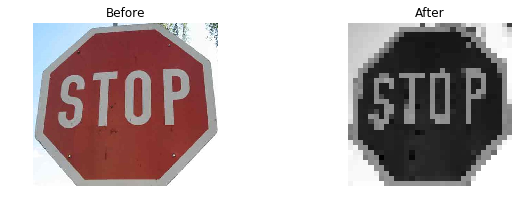

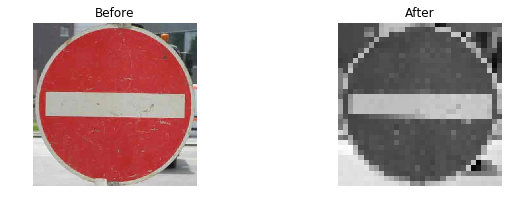

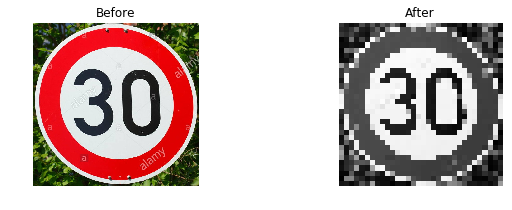

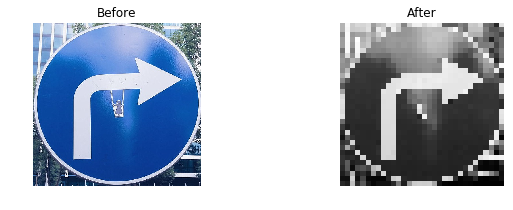

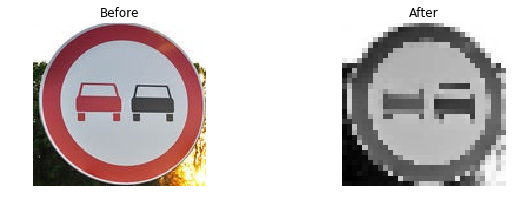

In [25]:
for image in my_images:
    new_img = cv2.cvtColor(image, color)
    new_img = cv2.resize(new_img, (32, 32))
    
    processed_images.append(new_img)
    show(image, new_img)
    
processed_images = np.asarray(processed_images) 
processed_images = (processed_images / img_max) - 0.5

if len(processed_images.shape) < 4:
    processed_images = np.expand_dims(processed_images, axis=3)

### Predict the Sign Type for Each Image

In [26]:
import tensorflow as tf

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(processed_images, my_labels)
    accuracy_percent = test_accuracy * 100.0
    print("Test Accuracy = {:d} %".format(int(accuracy_percent)))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 60 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet


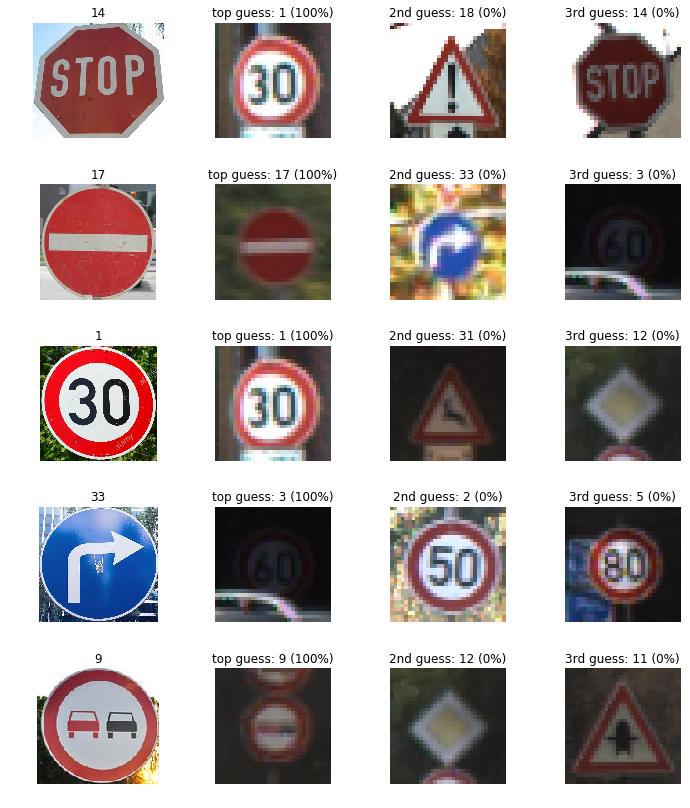

In [27]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)

# Calculate top_k guesses for web images
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: processed_images, dropout: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: processed_images, dropout: 1.0})

    
    # Show Images and guess percentages
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(image)
        axs[4*i].set_title(str(my_labels[i]))
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(test_labels == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(test_images[index1].squeeze())
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(test_labels == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(test_images[index2].squeeze())
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(test_labels == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(test_images[index3].squeeze())
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [28]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    i = 1
    for featuremap in range(featuremaps):
        img_act = activation[0,:,:, featuremap]
        if (np.abs(np.sum(img_act))) > 2:

            plt.subplot(6,8, i) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            i += 1

> Layer 1

INFO:tensorflow:Restoring parameters from ./lenet


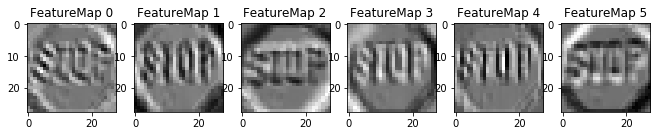

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    conv1 = sess.graph.get_tensor_by_name('conv1:0')
    
    outputFeatureMap(processed_images, conv1)

> Layer 2

INFO:tensorflow:Restoring parameters from ./lenet


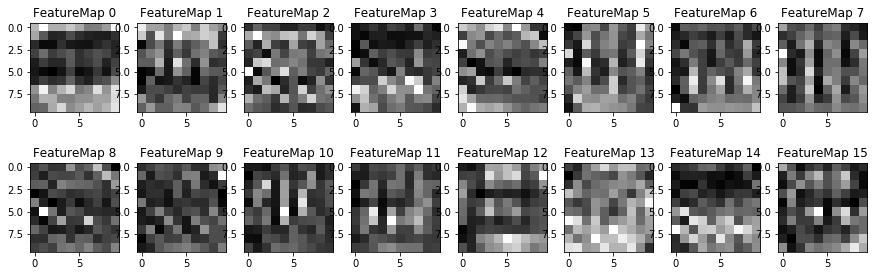

In [30]:
with tf. Session() as sess:
    saver.restore(sess, "./lenet")
    conv2 = sess.graph.get_tensor_by_name('conv2:0')
    
    outputFeatureMap(processed_images, conv2)

INFO:tensorflow:Restoring parameters from ./lenet


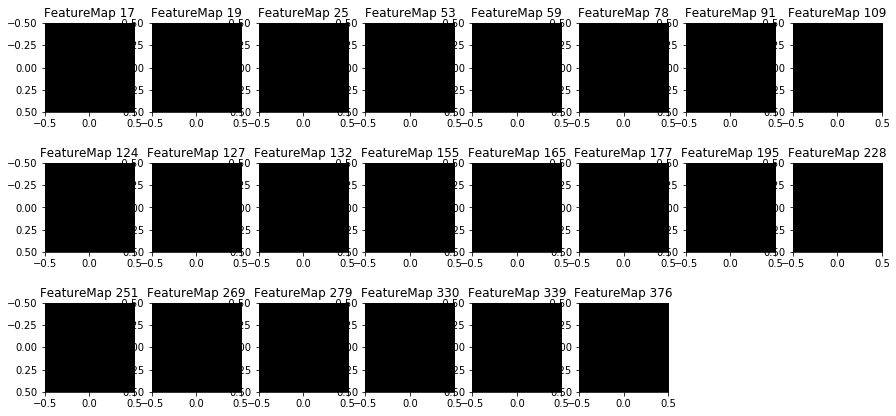

In [31]:
with tf. Session() as sess:
    saver.restore(sess, "./lenet")
    conv3 = sess.graph.get_tensor_by_name('conv3:0')
    
    outputFeatureMap(processed_images, conv3)